In [1]:
import numpy as np
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, MaxPooling2D, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import random
import cv2
from keras.utils import plot_model 
from skimage.util import random_noise

Using TensorFlow backend.


In [3]:
with np.load('data/training-dataset.npz') as data:
    img = data['x']
    lbl = data['y']

In [1146]:
np.unique(lbl)

(124800,)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=uint8)

### Reshaping image to 30x28 for easier use in task 2

In [ ]:
img = img.reshape(-1,28,28)
img_noise = []
for i in img:
    noise = np.zeros((30,28))
    noise[:i.shape[0],:i.shape[1]] = i
    img_noise.append(noise)

In [ ]:
img_noise = np.array(img_noise)

In [ ]:
img_noise = img_noise.reshape(-1,30,28,1)
img_noise.shape

### Adding noise 

In [ ]:
img_noise = random_noise(img_noise, mode='s&p', amount=0.1)

### splitting the data

In [ ]:
y = to_categorical(lbl)
X_train, X_test, y_train, y_test = train_test_split(img_noise, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

### Creating the model and running the model

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (30,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(27, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
plot_model(model, to_file='model.png',rankdir='LR')

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

In [ ]:
def plot_history(history):# Plot the loss and accuracy
    # Format the train history
    history_df = pd.DataFrame(history.history, columns=history.history.keys())
    display(history_df)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(history_df.shape[1]):
        ax.plot(history_df.iloc[:,i], label=history_df.columns[i])
    ax.legend()
    plt.title('Score() and loss during training.')
    plt.xlabel('Training step')
    plt.ylabel('Accuracy and Loss')
    plt.grid(b=True, which='major', axis='both')
    plt.show()

plot_history(history)

In [ ]:
model.save("noise_30x28_model.h5")

### Classification report 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(20,20))
j=0
for i in range(0,100):
    plt.subplot(10,10,j+1),plt.imshow(X_test[j].reshape(30,28)), plt.axis('off')
    plt.title('{} / {}'.format(y_test[j], y_pred[j]))
    j+=1
plt.suptitle('Actual vs. Predicted Labels', size=20)
plt.show()

### There is a wrong Label in the code?
model gets it right but the i is wrongly labeled

In [ ]:
plt.imshow(X_test[1].reshape(30,28))
y_pred[1]

In [ ]:
actual = y_test[1]
np.argmax(actual,axis=0)

# task 2

In [5]:
test = np.load('data/test-dataset.npy')

(10000, 30, 168)


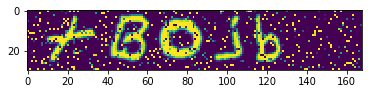

In [6]:
print(test.shape)
plt.imshow(test[-1])

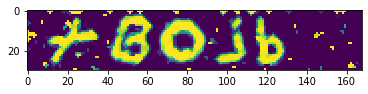

In [56]:
# Noise is of type 'Salt and Pepper' -> Best denoising method is median filter
# Denoise all images in the test set
from scipy import ndimage
test_denoised = []
for i in range(len(test)):
    new = ndimage.median_filter(test[i], 2)
    test_denoised.append(ndimage.median_filter(new, 2))
plt.imshow(test_denoised[-1])

In [ ]:
# find contours for the letters within the image
test_separated = []
deleted_array_count = 0
for k in range(len(test_denoised)):
    current_image = test_denoised[k].copy()
    im=current_image.astype('uint8')
    ret, thresh = cv2.threshold(im.copy(), 50, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    # x,y,w,h = cv2.boundingRect(contours[i]) 
    # get x, y, width, height to form the bounding box of each letter
    bb=[]
    deleted=[]
    separated = []
    separated_max = []
    bb = [cv2.boundingRect(contours[i]) for i in range(len(contours))]
    for i in range(len(bb)):
        if np.max(current_image[bb[i][1]:bb[i][1]+bb[i][3], bb[i][0]:bb[i][0]+bb[i][2]])>255:
            separated_max.append((i,np.where(current_image[bb[i][1]:bb[i][1]+bb[i][3], bb[i][0]:bb[i][0]+bb[i][2]]==np.max(current_image[bb[i][1]:bb[i][1]+bb[i][3], bb[i][0]:bb[i][0]+bb[i][2]]))[0][0]))
            #print('done')
        if (bb[i][2] < 20) & (bb[i][3] < 17): # if too small to be a letter
            deleted.append(bb[i])
            #print('deleted')
        if bb[i][2] >= 30:  # if bounding box too large and contains two letters
            if i not in separated_max:
                separated.append(i)
                #print('separated')
                      
    for i,m in separated_max:
        if bb[i] not in deleted:
                new = bb[i] # create new bounding box with half width
                bb[i] = (int(bb[i][0]),int(bb[i][1]),m,int(bb[i][3])) # halve the width
                new = (int(bb[i][0])+m, int(bb[i][1]), int(new[0])+int(new[2])-m, int(bb[i][3])) # # create new bounding box with half width and move its x to x + width/2
                bb.append(new)
                
    for i in separated:
        if (((len(separated_max)>0) and (i not in np.array(separated_max)[:,0])) or (len(separated_max)==0)):
            bb[i] = (bb[i][0],bb[i][1],int(bb[i][2]/2),bb[i][3]) # halve the width
            new = bb[i] # create new bounding box with half width
            new = (int(bb[i][0]) + int(bb[i][2]), int(bb[i][1]), int(bb[i][2]), int(bb[i][3])) # # create new bounding box with half width and move its x to x + width/2
            bb.append(new)
    
    for element in sorted(deleted, reverse=True): # remove bounding boxes that don't surround a letter
        bb.remove(element)
                          
    widths=[]
    heights=[]  
    bb = sorted(np.array(bb), key=lambda x: x[0]) # ascending sort by x, i.e. letters from left to right
    temp = []
    temporary = []
    for i in range(len(bb)):
        temp = current_image[bb[i][1]:bb[i][1]+bb[i][3], bb[i][0]:bb[i][0]+bb[i][2]]
        if temp[0].shape > np.max(3):
            temporary.append(temp)    
        else:
            print('deleted array of size 0')
            deleted_array_count +=1
    test_separated.append(temporary)
test_separated = np.array(test_separated)

In [58]:
len(test_separated)

10000

(array([2.400e+01, 0.000e+00, 8.620e+02, 0.000e+00, 8.578e+03, 0.000e+00,
        4.280e+02, 0.000e+00, 1.050e+02, 3.000e+00]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

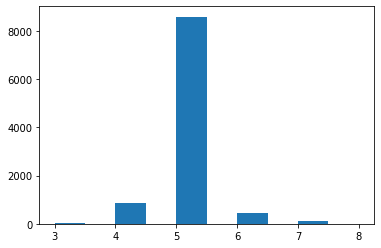

In [124]:
# over 90% of images were separated into 5 letters, but still many into !=5 letters
l=[]
for i in range(len(test_separated)):
    l.append(len(test_separated[i]))
plt.hist(l)

(array([4588.,  130.,  138.,  137.,  174.,  132.,  202.,  270.,  604.,
        3625.]),
 array([255. , 280.5, 306. , 331.5, 357. , 382.5, 408. , 433.5, 459. ,
        484.5, 510. ]),
 <a list of 10 Patch objects>)

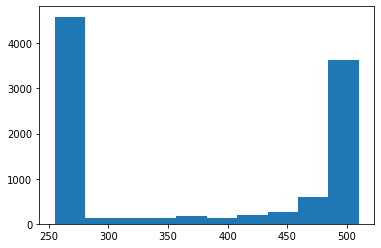

In [125]:
# almost half of images have pixel max 255, but many have it >255, suggesting an overlap of letters
# hint: where max>255, two letters overlap, so better to set the pixel location as separation point (done above)
a=[]
for i in range(10000):
    a.append(np.max(test[i]))
plt.hist(a)

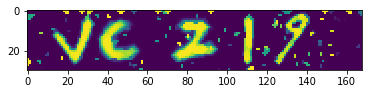

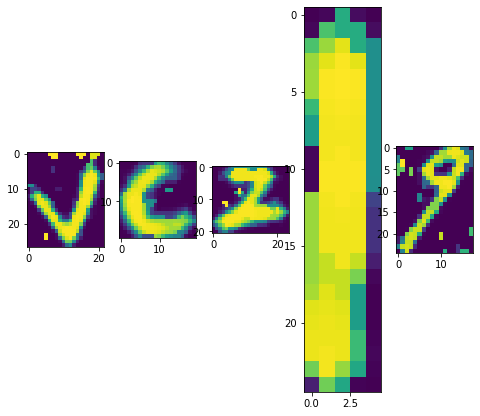

In [113]:
plt.imshow(test_denoised[1])
plt.show()

fig=plt.figure(figsize=(8, 8))
for i in range(len(test_separated[1])):
    fig.add_subplot(1,len(test_separated[1]),i+1)
    plt.imshow(test_separated[1][i])

In [117]:
use_samples = test_separated[180]
block_size = 55
noise_removed = []
predictions = []
for sample in use_samples:
    imbw = sample > filters.threshold_local(sample, block_size, method = 'mean')
    imbw1 = remove_small_objects(imbw, 10, connectivity=1)
    roi = imbw1
    roi = roi.reshape((roi.shape[0],roi.shape[1],1))
    roi = tf.image.resize_with_crop_or_pad(roi, 30, 28).numpy()
    image = roi.reshape(30,28)
    prediction1 = model.predict_classes(image.reshape(-1,30,28,1))
    predictions.append(prediction1)

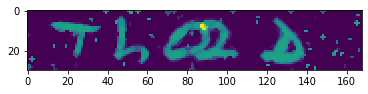

In [118]:
plt.imshow(test_denoised[180])

In [119]:
predictions

[array([20], dtype=int64),
 array([8], dtype=int64),
 array([10], dtype=int64),
 array([4], dtype=int64)]

# Generating Predictions of the images

In [120]:
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
from skimage.color import label2rgb
from skimage import filters
import tensorflow as tf
from keras.models import load_model

model = load_model('noise_30x28_model.h5')

predictions1 = []
predictions2 = []
predictions3 = []
predictions4 = []
predictions5 = []
images = []
connected_c = []
final = []
for i in test_separated:
    for j in i:
        imbw = j > filters.threshold_local(j, block_size, method = 'mean')
        imbw1 = remove_small_objects(imbw, 10, connectivity=1)
        roi = imbw1
        roi = roi.reshape((roi.shape[0],roi.shape[1],1))
        roi = tf.image.resize_with_crop_or_pad(roi, 30, 28).numpy()
        image = roi.reshape(30,28)
        prediction1 = model.predict_classes(image.reshape(-1,30,28,1))
        prediction2 = model.predict_classes(image.reshape(-1,30,28,1))
        prediction3 = model.predict_classes(image.reshape(-1,30,28,1))
        prediction4 = model.predict_classes(image.reshape(-1,30,28,1))
        prediction5 = model.predict_classes(image.reshape(-1,30,28,1))
        images.append(image)
        predictions1.append(prediction1)
        predictions2.append(prediction2)
        predictions3.append(prediction3)
        predictions4.append(prediction4)
        predictions5.append(prediction5)    
    connected = np.concatenate(images, axis=1)
    pred_connect1 = np.concatenate(predictions1)
    pred_connect2 = np.concatenate(predictions2)
    pred_connect3 = np.concatenate(predictions3)
    pred_connect4 = np.concatenate(predictions4)
    pred_connect5 = np.concatenate(predictions5)
    
    a_str1 = pred_connect1.astype(str)
    a_str2 = pred_connect2.astype(str)
    a_str3 = pred_connect3.astype(str)
    a_str4 = pred_connect4.astype(str)
    a_str5 = pred_connect5.astype(str)
    
    a_str1_1= np.char.zfill(a_str1, 2)
    a_str1_2= np.char.zfill(a_str2, 2)
    a_str1_3= np.char.zfill(a_str3, 2)
    a_str1_4= np.char.zfill(a_str4, 2)
    a_str1_5= np.char.zfill(a_str5, 2)
    
    a_str2_1 = ''.join(a_str1_1)
    a_str2_2 = ''.join(a_str1_2)
    a_str2_3 = ''.join(a_str1_3)
    a_str2_4 = ''.join(a_str1_4)
    a_str2_5 = ''.join(a_str1_5)
    
    predictions_c = []
    connected_c.append(connected) 
    predictions_c.append(a_str2_1)
    predictions_c.append(a_str2_2)
    predictions_c.append(a_str2_3)
    predictions_c.append(a_str2_4)
    predictions_c.append(a_str2_5)
    final1 = predictions_c.copy()
    final.append(final1)
    predictions1.clear()
    predictions2.clear()
    predictions3.clear()
    predictions4.clear()
    predictions5.clear()
    
    predictions_c.clear()
    images.clear()  

In [121]:
import csv
with open('Predictions.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerows(final)